In [1]:
import gudhi as gd
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import utils
from random import choice, sample

with open("data/Drugbank2019_MS_CFMID4.0.json", mode = "r") as drugbank:
    db = json.load(drugbank)

In [2]:
from gtda.homology import EuclideanCechPersistence,VietorisRipsPersistence
from gtda.diagrams import PersistenceImage
from gtda.pipeline import Pipeline
from gtda.diagrams import Filtering

In [3]:
mol_str = "CN(C)CCCn1cc(C2=C(C(=O)NC2=O)c3c[nH]c4ccccc34)c5ccccc15"
idx = list(db.keys()).index(mol_str)

In [4]:
spectra = dict()

#mol_indices = list(sample(list(range(len(db))), 9701))
mol_strings = np.asarray(list(db.keys()))[ [idx] ]

for m in tqdm(mol_strings):
    energies = [
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy0"]["mz"] ]),
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy1"]["mz"] ]),
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy2"]["mz"] ])
    ]
    for i,energy in enumerate(energies):
        energies[i][:,0] = np.log(energy[:,0])/np.log(6000)
        
    spectra[m] = tuple(energies)

mol_strings = list(spectra.keys())
print(mol_strings)

  0%|          | 0/1 [00:00<?, ?it/s]

['CN(C)CCCn1cc(C2=C(C(=O)NC2=O)c3c[nH]c4ccccc34)c5ccccc15']


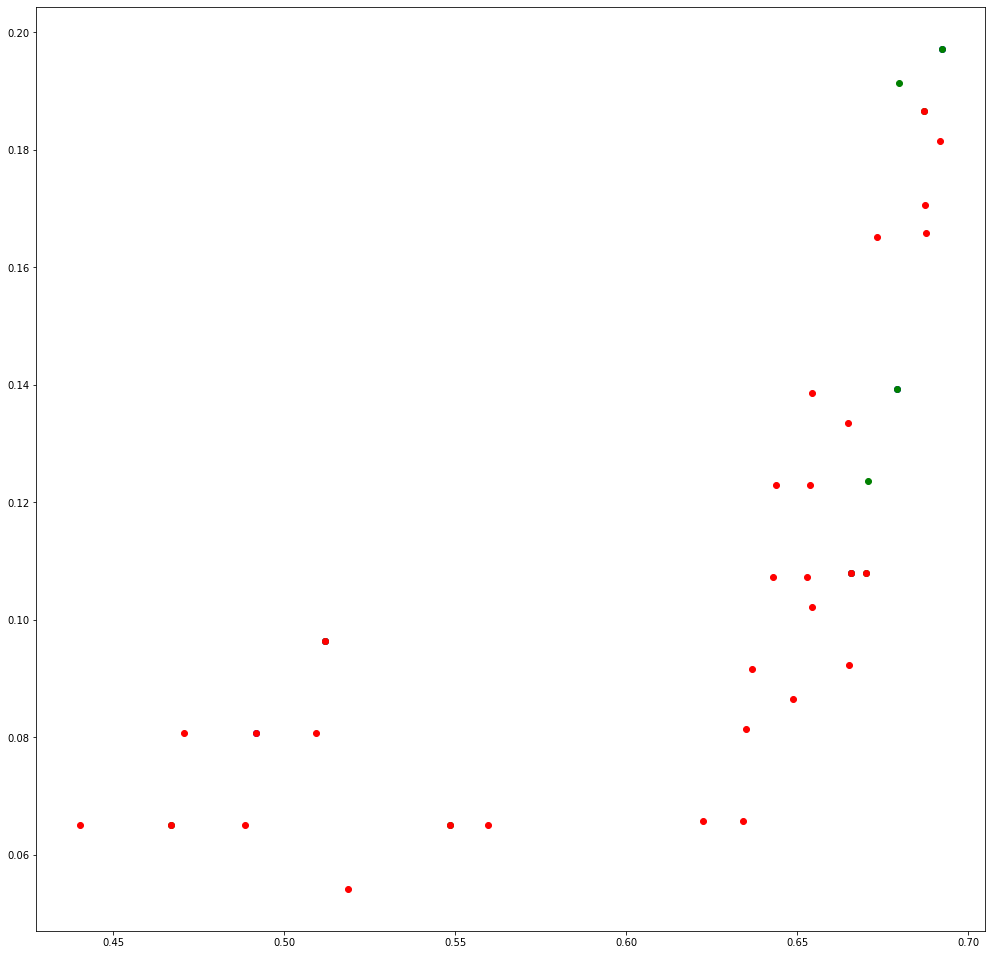

In [5]:
fig = plt.figure(figsize=(17,17))
ax = fig.add_subplot()
for mol_s in sample(mol_strings, min(len(mol_strings), 100) ):
    (X0,X1,X2) = spectra[ mol_s ]
    ax.scatter(X0[:,0],X0[:,1], color = "blue")
    ax.scatter(X1[:,0],X1[:,1], color = "green")
    ax.scatter(X2[:,0],X2[:,1], color = "red")

In [6]:
spectra

{'CN(C)CCCn1cc(C2=C(C(=O)NC2=O)c3c[nH]c4ccccc34)c5ccccc15': (array([[0.49159824, 0.08078   ],
         [0.5120225 , 0.09643   ],
         [0.66590077, 0.10805   ],
         [0.67912787, 0.13935   ],
         [0.69238892, 0.1972    ]]),
  array([[0.46674362, 0.06513   ],
         [0.5120225 , 0.09643   ],
         [0.54838514, 0.06513   ],
         [0.66590077, 0.10805   ],
         [0.67003112, 0.10805   ],
         [0.67070531, 0.1237    ],
         [0.67912787, 0.13935   ],
         [0.6797509 , 0.19139   ],
         [0.68726658, 0.18664   ],
         [0.69238892, 0.1972    ]]),
  array([[0.44009827, 0.06513   ],
         [0.46674362, 0.06513   ],
         [0.47064057, 0.08078   ],
         [0.48836003, 0.06513   ],
         [0.49159824, 0.08078   ],
         [0.50931769, 0.08078   ],
         [0.5120225 , 0.09643   ],
         [0.51851852, 0.05423   ],
         [0.54838514, 0.06513   ],
         [0.55951793, 0.06513   ],
         [0.622575  , 0.06585   ],
         [0.63422536, 0.065

In [31]:
def compute_cech_persistence(spectra):
    pipeline = Pipeline([
        ('diagram', EuclideanCechPersistence(
            homology_dimensions = [0,1,2],
            max_edge_length = np.sqrt(2),
            n_jobs = 3,
        )),
        ('filtering', Filtering()),
        ('image', PersistenceImage(n_bins = 50, n_jobs = 3)),
    ])
    # dictionary of 3-tuples of point clouds
    molecules = list(spectra.keys())
    x0 = [ X[0] for X in spectra.values() ]
    x1 = [ X[1] for X in spectra.values() ]
    x2 = [ X[2] for X in spectra.values() ]
    data = (
        pipeline.fit_transform(x0),
        pipeline.fit_transform(x1),
        pipeline.fit_transform(x2),
    )
    data = np.concatenate(data, axis = 1)
    return molecules, data

In [32]:
mols, data = compute_cech_persistence(spectra)
print(data.shape)

(1, 9, 50, 50)


In [45]:
the_mol = mols[0]
the_image = data[0][[1,5,8]]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, .99))
r = scaler.fit_transform(the_image[0])
g = scaler.fit_transform(the_image[1])
b = scaler.fit_transform(the_image[2])

rgb_image = np.dstack((r,g,b))

print(the_mol)
print(the_image.shape)
print(rgb_image.shape)

CN(C)CCCn1cc(C2=C(C(=O)NC2=O)c3c[nH]c4ccccc34)c5ccccc15
(3, 50, 50)
(50, 50, 3)


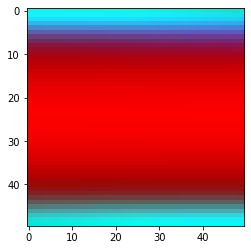

In [46]:
plt.imshow(rgb_image)